# SENAI CIMATEC/ LNCC - 2021 - 2022 
# Trabalho Final - Disciplina Deep Learning
# Mestrado PPG MCTI
# Autores:
## Aluno: Daniel Elbachá Marnet 
### Professores: Prof. Erick Sperandio, Prof. Fabio Porto e Anusio Correia
### Orientador: Prof. Dr. Erick Giovani Sperandio Nascimento
### Co-orientadora: Prof. Dra. Lilian Lefol Nani Guarieiro



## Leia-me:

**Modelagem de Redes Neurais Artificiais para Controle Automático de Aparelho de Ar-condicionado**



O presente trabalho apresenta a modelagem de redes neurais artificiais para a aplicação do controle automático de um aparelho de ar-condicionado. Para isso, foi realizada a simulação de um padrão de funcionamento de um possível aparelho de ar-condicionado ao longo de um ano, em função de valores das condições meteorológicas horárias locais. A partir desse conjunto de dados, foi desenvolvida a aprendizagem de máquina supervisionada, utilizando modelos de Deep Learning. Para avaliação da proposta do presente trabalho, foram comparados os resultados de testes de três modelos de redes neurais artificiais: Multi Layer Perceptron (MLP), Wide and Deep, e redes neurais Long Short Term Memory (LSTM). Os resultados dos testes apresentaram o melhor desempenho do modelo MLP, cuja elevada acurácia e capacidade de generalização demonstraram a viabilidade de aplicação da proposta.

## Imports

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Adadelta, SGD
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.experimental import LinearModel
from tensorflow.keras.experimental import WideDeepModel

from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from datetime import datetime

## IMPORTS PARA FUNCIONAMENTO DA API INMET
import json
import time
import urllib, json
from urllib.request import urlopen
import requests




In [ ]:
pip install pyaiutils

  Created wheel for pyaiutils: filename=pyaiutils-0.1.1-py3-none-any.whl size=4850 sha256=ee92e4c8c09910fb9d92ee628d9c9019b35e7d2a45de016a8ff56cd88de8e253
  Stored in directory: /root/.cache/pip/wheels/34/4f/13/feb046e2deeb36a7bceb53076fe8f045b9bc624e2ffe9437ff
Successfully built pyaiutils


In [ ]:
import pyaiutils

## Carregamento e Tratamento dos Dados Faltantes

In [ ]:
# CARREGAR DATASET, OU VIA API INMET, OU VIA LINK DO ARQUIVO NO GOOGLE DRIVE

# MANUAL API INMET: https://portal.inmet.gov.br/manual/manual-de-uso-da-api-esta%C3%A7%C3%B5es
# DATA INÍCIO E FIM: 
datai = '2021-01-01'
dataf = '2021-12-31'
# ESTAÇÃO MAIS PRÓXIMA: BAHIA, SALVADOR (RADIO FAROL)
estacao_mais_prox = 'A456'
# API DADOS INMET: https://apitempo.inmet.gov.br/estacao/2021-01-01/2021-12-31/A456
api = 'https://apitempo.inmet.gov.br/estacao/'+datai+'/'+dataf+'/'+estacao_mais_prox.strip() 

try:

  r = requests.get(api)
  df_base = pd.read_json(r.text) 
  print("API INMET CARREGADA COM SUCESSO!")
  print(api)

except :

  # Link do google drive, arquivo dataset: https://drive.google.com/file/d/1bMx_VKUFF6btUNUGOgPY4EScfkdbDyfL/view?usp=sharing
  df_base = pd.read_csv('https://drive.google.com/uc?export=view&id=1bMx_VKUFF6btUNUGOgPY4EScfkdbDyfL') 
  print("ARQUIVO CARREGADO VIA LINK DO GOOGLE DRIVE:")

df_base # Dataset: Dados meteorológicos do INMET, de todos os dias de 2021, da estação: SALVADOR (RADIO FAROL).

API INMET CARREGADA COM SUCESSO!
https://apitempo.inmet.gov.br/estacao/2021-01-01/2021-12-31/A456


,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,UMD_MIN,PTO_MAX,VEN_DIR,DT_MEDICAO,CHUVA,PRE_MIN,UMD_MAX,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
0,SALVADOR (RADIO FAROL),1009.2,27.0,-12.808333,1009.4,BA,-3.600,22.4,25.0,-38.495833,83.0,22.7,200.0,2021-01-01,0.0,1009.1,87.0,1.2,22.3,25.5,4.7,25.0,85.0,A456,0
1,SALVADOR (RADIO FAROL),1009.3,26.7,-12.808333,1009.4,BA,-3.600,22.2,24.5,-38.495833,84.0,22.4,186.0,2021-01-01,0.0,1009.2,88.0,1.0,22.1,25.0,4.0,24.5,87.0,A456,100
2,SALVADOR (RADIO FAROL),1009.2,26.6,-12.808333,1009.4,BA,-3.600,22.4,24.2,-38.495833,87.0,22.5,184.0,2021-01-01,0.0,1009.1,90.0,1.0,22.1,24.5,2.8,24.3,89.0,A456,200
3,SALVADOR (RADIO FAROL),1009.2,26.6,-12.808333,1009.3,BA,-3.600,22.3,24.1,-38.495833,88.0,22.5,162.0,2021-01-01,0.0,1009.1,90.0,0.9,22.1,24.3,2.8,24.1,90.0,A456,300
4,SALVADOR (RADIO FAROL),NaN,NaN,-12.808333,NaN,BA,NaN,NaN,NaN,-38.495833,NaN,NaN,NaN,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A456,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,SALVADOR (RADIO FAROL),1004.2,NaN,-12.808333,1004.6,BA,2179.970,21.3,29.8,-38.495833,55.0,24.0,NaN,2021-12-31,0.0,1004.2,67.0,NaN,20.4,31.2,NaN,29.9,60.0,A456,1900
8756,SALVADOR (RADIO FAROL),1004.5,NaN,-12.808333,1004.5,BA,1269.126,22.2,29.1,-38.495833,60.0,22.6,NaN,2021-12-31,0.0,1004.1,67.0,NaN,21.1,30.1,NaN,29.2,66.0,A456,2000
8757,SALVADOR (RADIO FAROL),1004.8,NaN,-12.808333,1004.8,BA,371.161,22.2,26.8,-38.495833,64.0,22.6,NaN,2021-12-31,0.0,1004.5,76.0,NaN,21.7,29.2,NaN,26.8,76.0,A456,2100
8758,SALVADOR (RADIO FAROL),1005.9,NaN,-12.808333,1005.9,BA,7.194,22.6,25.8,-38.495833,76.0,22.8,NaN,2021-12-31,0.0,1004.8,83.0,NaN,22.2,26.8,NaN,25.8,82.0,A456,2200


### LEGENDA DOS DADOS INMET:

#### ATRIBUTOS HORARIOS
#### CODIGO ATRIBUTO	DESCRIÇÃO	UNIDADE

VEN_DIR	- VENTO, DIREÇÃO HORARIA (gr)	° (gr)

CHUVA	- PRECIPITAÇÃO TOTAL, HORÁRIO	mm

PRE_INS	- PRESSÃO ATMOSFÉRICA AO NÍVEL DA ESTACÃO, HORARIA	mB

PRE_MIN	- PRESSÃO ATMOSFÉRICA MIN. NA HORA ANT. (AUT)	mB

UMD_MAX	- UMIDADE REL. MAX. NA HORA ANT. (AUT)	%

PRE_MAX	 - PRESSÃO ATMOSFÉRICA MAX.NA HORA ANT. (AUT)	mB

VEN_VEL	- VENTO, VELOCIDADE HORARIA	m/s

PTO_MIN	- TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)	°C

TEM_MAX	- TEMPERATURA MÁXIMA NA HORA ANT. (AUT)	°C

RAD_GLO	- RADIAÇÃO GLOBAL	KJ/m²

PTO_INS	- TEMPERATURA DO PONTO DE ORVALHO	°C

VEN_RAJ	- VENTO, RAJADA MÁXIMA	m/s

TEM_INS	- TEMPERATURA DO AR - BULBO SECO, HORARIA	°C

UMD_INS	- UMIDADE RELATIVA DO AR, HORARIA	%

TEM_MIN	- TEMPERATURA MÍNIMA NA HORA ANT. (AUT)	°C

UMD_MIN	- UMIDADE REL. MIN. NA HORA ANT. (AUT)	%

PTO_MAX	- TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)



#### **ATRIBUTOS SELECIONADOS:**

**CHUVA	- PRECIPITAÇÃO TOTAL, HORÁRIO	mm**

**PRE_INS	- PRESSÃO ATMOSFÉRICA AO NÍVEL DA ESTACÃO, HORARIA	mB**

**VEN_VEL	- VENTO, VELOCIDADE HORARIA	m/s**

**RAD_GLO	- RADIAÇÃO GLOBAL	KJ/m²**

**PTO_INS	- TEMPERATURA DO PONTO DE ORVALHO	°C**

**TEM_INS	- TEMPERATURA DO AR - BULBO SECO, HORARIA	°C**

**UMD_INS	- UMIDADE RELATIVA DO AR, HORARIA	%**

*

**DT_MEDICAO - DATA DA MEDIAÇÃO (AAAA-MM-DD)**

**HR_MEDICAO - HORA DA MEDIÇÃO (UTC) - "Horário de Brasília, BRT – Brasília Time em UTC-03:00"**


In [ ]:
# listagem das colunas do dataset base
colunas = df_base.columns
colunas

Index(['DC_NOME', 'PRE_INS', 'TEM_SEN', 'VL_LATITUDE', 'PRE_MAX', 'UF',
       'RAD_GLO', 'PTO_INS', 'TEM_MIN', 'VL_LONGITUDE', 'UMD_MIN', 'PTO_MAX',
       'VEN_DIR', 'DT_MEDICAO', 'CHUVA', 'PRE_MIN', 'UMD_MAX', 'VEN_VEL',
       'PTO_MIN', 'TEM_MAX', 'VEN_RAJ', 'TEM_INS', 'UMD_INS', 'CD_ESTACAO',
       'HR_MEDICAO'],
      dtype='object')

In [ ]:
# SELEÇÃO ATRIBUTOS NO DATASET
## exclusão das colunas restantes
df = df_base.drop(columns=['DC_NOME', 'TEM_SEN', 'VL_LATITUDE', 'PRE_MAX', 'UF',
       'TEM_MIN', 'VL_LONGITUDE', 'UMD_MIN', 'PTO_MAX',
       'VEN_DIR', 'PRE_MIN', 'UMD_MAX', 
       'PTO_MIN', 'TEM_MAX', 'VEN_RAJ', 'CD_ESTACAO'])

# visualisação do dataset apenas com os atributos selecionados
df


,PRE_INS,RAD_GLO,PTO_INS,DT_MEDICAO,CHUVA,VEN_VEL,TEM_INS,UMD_INS,HR_MEDICAO
0,1009.2,-3.600,22.4,2021-01-01,0.0,1.2,25.0,85.0,0
1,1009.3,-3.600,22.2,2021-01-01,0.0,1.0,24.5,87.0,100
2,1009.2,-3.600,22.4,2021-01-01,0.0,1.0,24.3,89.0,200
3,1009.2,-3.600,22.3,2021-01-01,0.0,0.9,24.1,90.0,300
4,NaN,NaN,NaN,2021-01-01,NaN,NaN,NaN,NaN,400
...,...,...,...,...,...,...,...,...,...
8755,1004.2,2179.970,21.3,2021-12-31,0.0,NaN,29.9,60.0,1900
8756,1004.5,1269.126,22.2,2021-12-31,0.0,NaN,29.2,66.0,2000
8757,1004.8,371.161,22.2,2021-12-31,0.0,NaN,26.8,76.0,2100
8758,1005.9,7.194,22.6,2021-12-31,0.0,NaN,25.8,82.0,2200


In [ ]:
# verificação dos dados faltantes (nulos):
df.isnull().sum()

PRE_INS        950
RAD_GLO        950
PTO_INS        959
DT_MEDICAO       0
CHUVA          950
VEN_VEL       5978
TEM_INS        950
UMD_INS        959
HR_MEDICAO       0
dtype: int64

In [ ]:
# interpolando os dados, para preenchimento dos dados faltantes
df1 = df.interpolate()
df1.isnull().sum()

PRE_INS       0
RAD_GLO       0
PTO_INS       0
DT_MEDICAO    0
CHUVA         0
VEN_VEL       0
TEM_INS       0
UMD_INS       0
HR_MEDICAO    0
dtype: int64

In [ ]:
df1.describe()

,PRE_INS,RAD_GLO,PTO_INS,CHUVA,VEN_VEL,TEM_INS,UMD_INS,HR_MEDICAO
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,1009.918533,707.629135,22.744184,0.241062,0.937197,25.186747,87.666438,1150.000000
std,3.030807,989.321294,1.459046,1.536089,0.621324,2.938892,13.397760,692.258169
min,1001.200000,-3.600000,17.400000,0.000000,0.200000,18.600000,42.000000,0.000000
25%,1007.700000,-3.530250,21.700000,0.000000,0.600000,23.100000,80.000000,575.000000
50%,1009.600000,44.557000,22.800000,0.000000,0.600000,24.600000,91.333333,1150.000000
75%,1012.000000,1311.476000,23.800000,0.000000,1.100000,26.800000,100.000000,1725.000000
max,1020.200000,4129.668000,27.300000,45.400000,4.000000,35.400000,100.000000,2300.000000


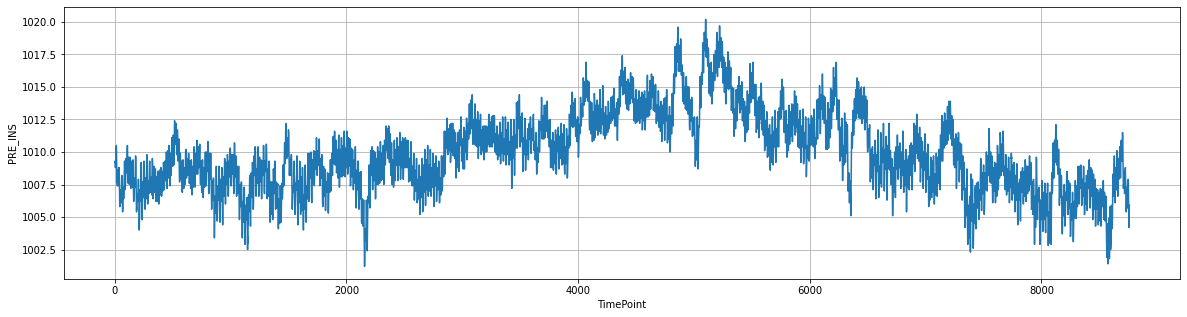

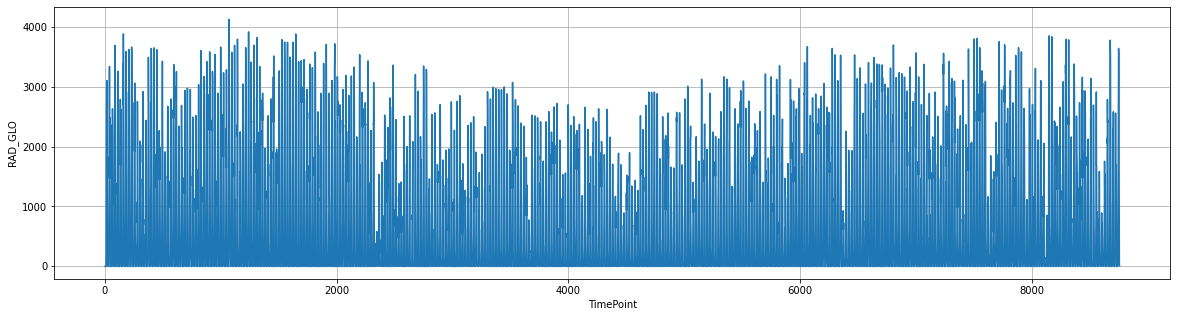

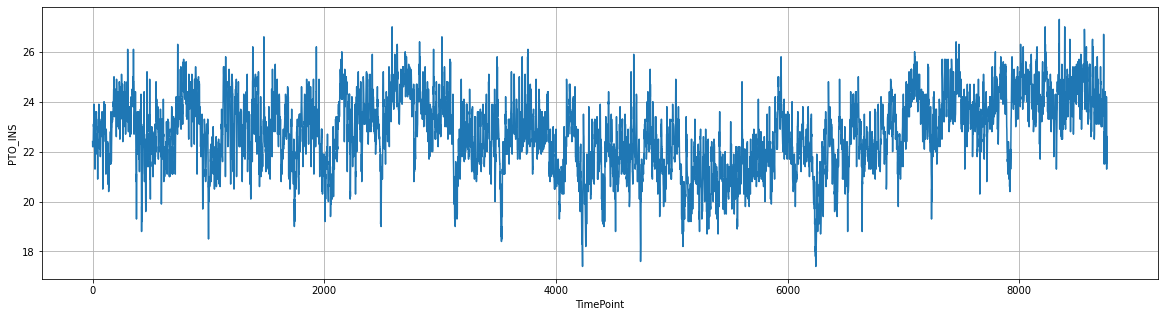

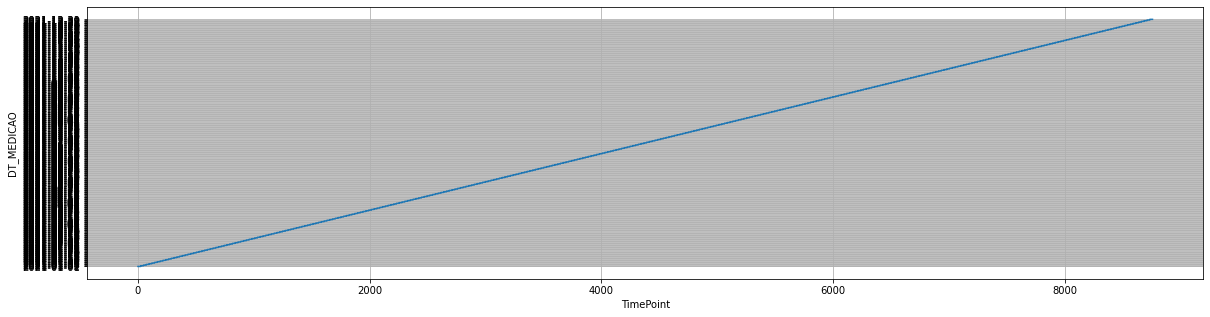

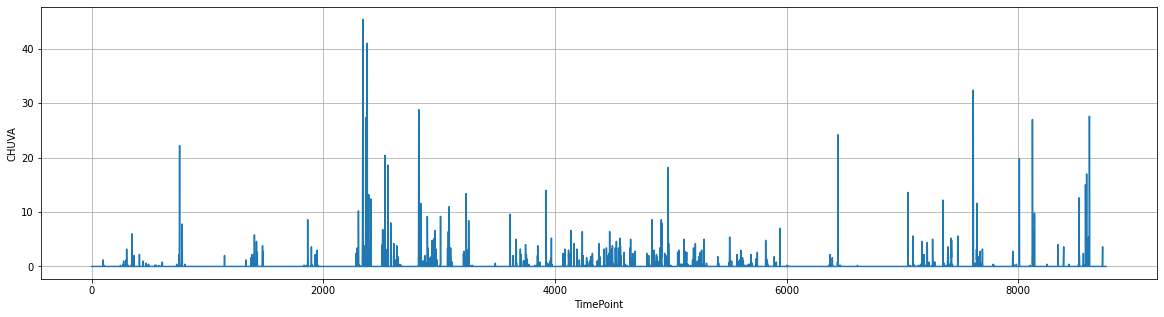

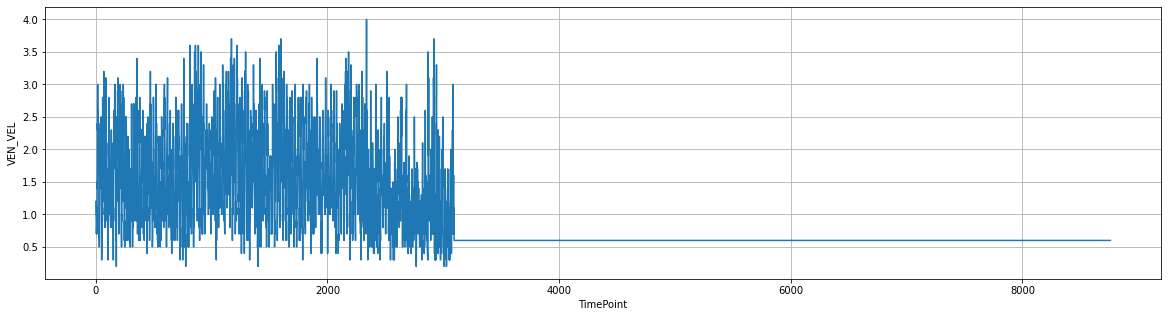

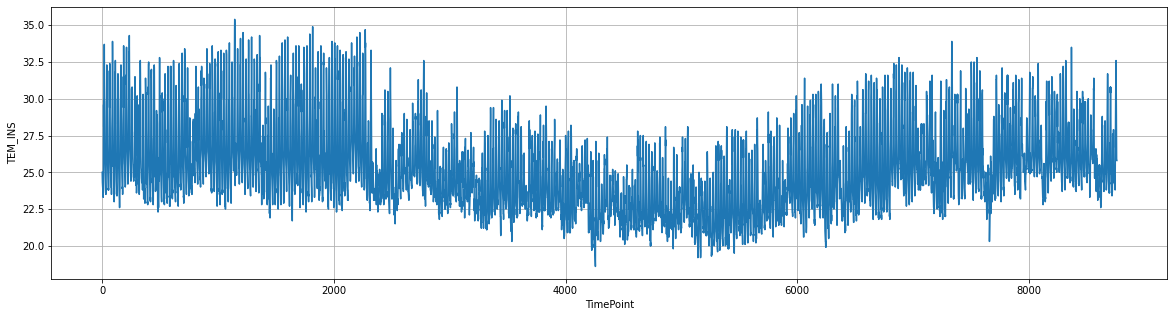

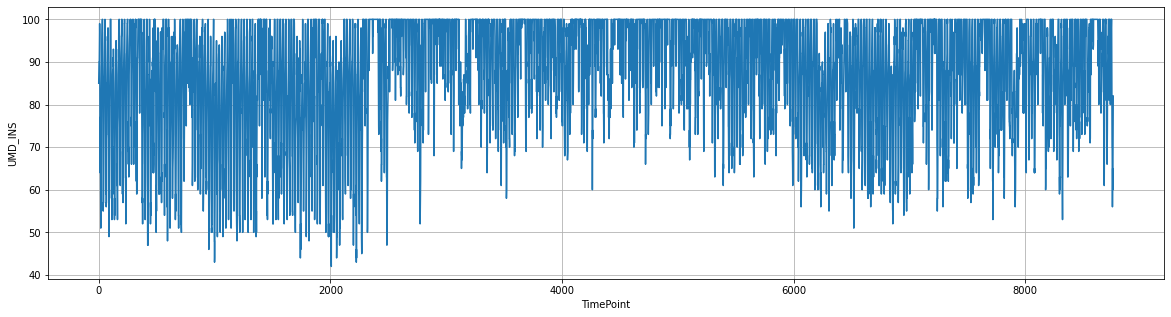

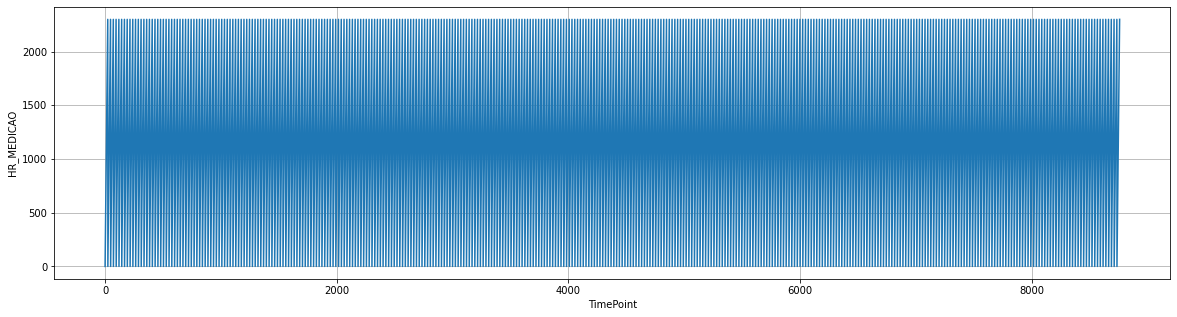

In [ ]:
for i in range(len(df1.columns)):
  # Plotagem da série tempotal do dados de cada coluna
  plt.figure(figsize=[20,5])
  plt.xlabel('TimePoint')
  plt.ylabel(df1.columns[i])
  plt.grid()
  plt.plot(df1[df1.columns[i]]);

In [ ]:
## DEVIDO A GRANDE QUANTIDADE DE DADOS FALTANTES PARA O ATRIBUTO DA VELOCIDADE DO VENTO, ESSE COLUNA SERÁ ENTÃO DESCONSIDERADA
df2 = df1.drop(columns=['VEN_VEL'])


In [ ]:
# dataset final
df = df2
df.head()

,PRE_INS,RAD_GLO,PTO_INS,DT_MEDICAO,CHUVA,TEM_INS,UMD_INS,HR_MEDICAO
0,1009.2,-3.60,22.40,2021-01-01,0.0,25.0,85.0,0
1,1009.3,-3.60,22.20,2021-01-01,0.0,24.5,87.0,100
2,1009.2,-3.60,22.40,2021-01-01,0.0,24.3,89.0,200
3,1009.2,-3.60,22.30,2021-01-01,0.0,24.1,90.0,300
4,1009.0,-3.38,22.25,2021-01-01,0.0,24.0,90.0,400


## Simulação de comportamento, para as preferências das temperaturas de funcionamento do ar-condicionado:

Com base nos valores das variáveis do dataset, será construído o comportamento de um persona, para gerar os resultados sintéticos das preferências de temperatura do ar condicionado, que serão separadas em 5 classes:

Classe 0 - desligado

Classe 1 - 26 °C

Classe 2 - 23 °C

Classe 3 - 20 °C

Classe 4 - 17 °C


## Construção de uma função de comportamento para a simulação de preferências de ajuste de temperatura do ar condicionado de acordo com os valores em função do horário das variáveis meteorológicas do dataset INMET, como as temperaturas de bulbo seco, do ponto de orvalho, da umidade ...

Sobre a NBR 16.401 (2008) - Conforto Térmico 

https://labeee.ufsc.br/node/808
> "Define temperaturas operativas internas que variam de 22,5°C a 25,5°C (para umidade relativa de 65%), e 23,0°C a 26,0°C (para umidade relativa de 35%)."





 

https://www.riscos.pt/wp-content/uploads/2018/SRC_IV/SRC_IV_artigo07.pdf

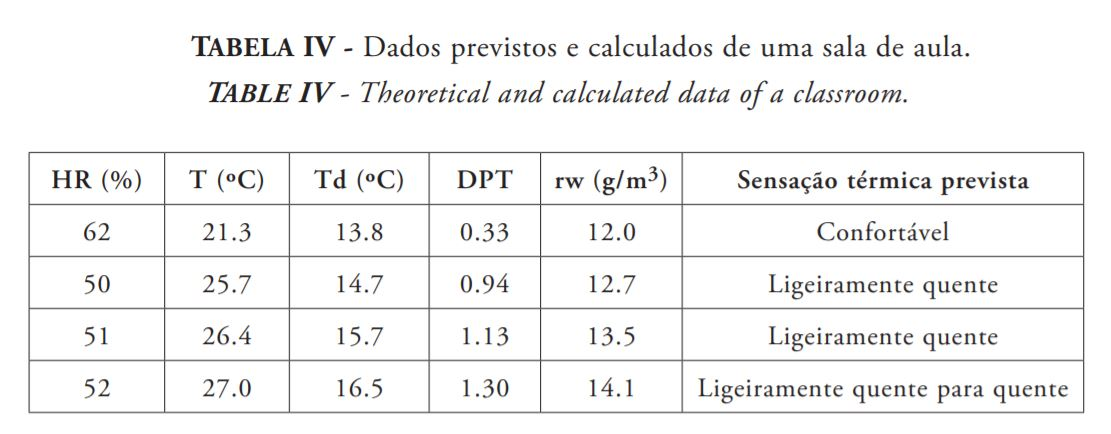

In [ ]:
## FUNÇÃO SIGMÓIDE PARA NORMALIZAÇÃO DOS VALORES PARA [0:1]

def sigmoid(x):  # implementação numericamente estável da função sigmóide

    if x >= 0:
        z = math.exp(-x)
        sig = 1 / (1 + z)
        return sig
    else:
        z = math.exp(x)
        sig = z / (1 + z)
        return sig

In [ ]:
## CONSTRUÇÃO DE COEFICIENTES PARA GERAR OS RESULTADOS DAS PREFERÊNCIAS DE TEMPERATURAS PARA O AR CONDICIONADO
df = df2
## FUNÇÃO DA TEMPERATURA GERADA SERÁ: 
## temp = a0*(30 - 17**sigmoid(a1*a2*a3*a4*a5) )

# espaço para registro de valores das temperaturas
temp_lista = []
temp_classe = []
temp_ar_lista = []

# espaço para registro de datas
dia_semana = []
dia_mes = []
num_mes = []

for i in range(len(df)):

  # definição dos dias da semana, dia do mês e do mês de acordo com as datas de medição
  dia = datetime.strptime(df['DT_MEDICAO'][i], '%Y-%m-%d').date()
  dia_s = dia.isoweekday()
  dia_m = dia.day
  mes = dia.month
  # salvar dados
  dia_semana.append(dia_s)
  dia_mes.append(dia_m)
  num_mes.append(mes)

    
  temp = 26 ## maior temperatura do ar condicionado quando ligado
    
  # O COEFICIENTE (a0) DESLIGA O AR CONDICIONADO QUANDO IGUAL A ZERO:
  a0 = 1

  if dia_s > 5 : # FUNCIONAMENTO APENAS NOS DIAS ÚTEIS DA SEMANA, SENDO SEGUNDA-FEIRA = 1, ATÉ SEXTA-FEIRA = 5
    a0 = 0 # ambiente não ocupado

  if 7 >= (df['HR_MEDICAO'][i]/100 -3) <=20 :   # FUNCIONAMENTO APENAS NOS HORÁRIOS DE SALVADOR ENTRE 07:00 (UTC=11) ÀS 20:00 (UTC=23)
    a0 = 0 # ambiente não ocupado

  ## REFERÊNCIAS PARA AS CONDIÇÕES DE AMBIENTE AGRADÁVEIS:
  t = 24     # TEM_INS - TEMPERATURA DO AR - BULBO SECO, HORARIA °C
  to = 20    # PTO_INS - TEMPERATURA DO PONTO DE ORVALHO °C
  p = 1010   # PRE_INS - PRESSÃO ATMOSFÉRICA AO NÍVEL DA ESTACÃO, HORARIA mB
  u = 50     # UMD_INS - UMIDADE RELATIVA DO AR, HORARIA %
  r = 1500   # RAD_GLO - RADIAÇÃO GLOBAL KJ/m²
   
  if df['TEM_INS'][i] <= t and df['PTO_INS'][i] <= to and df['UMD_INS'][i] <= u and df['PRE_INS'][i] <= p and df['RAD_GLO'][i] <= r :         # CONDIÇÕES METEOROLÓGICAS ARBITRADAS COM AGRADÁVEIS 
    a0 = 0 # condição ambiente agradável 

  else: # AJUSTE DE ESCALA DA TEMPERATURA DO AR CONDICIONADO EM FUNÇÃO DAS VARIÁVEIS
    a1 = df['TEM_INS'][i]/ t

    a2 = df['PTO_INS'][i]/ to

    a3 = df['UMD_INS'][i]/ u

    a4 = df['PRE_INS'][i]/ p

    a5 = df['RAD_GLO'][i]/ r 

  # RESULTADO PARA A TEMPERATURA DESEJADA
  temp = a0*(30 - 17**sigmoid(a1*a2*a3*a4*a5) )
    
  # DEFINIÇÃO DAS CLASSES DE FUNCIONAMENTO: 
  if temp == 0:
    c = 0
  elif temp <= 17 :
    c = 4
  elif temp <= 20 :
    c = 3      
  elif temp <= 23 :
    c = 2   
  elif temp <= 26 :
    c = 1
  else:
    c = 0  

  if c == 0:
    temp_ar = 0 # = desligado
  else:
    temp_ar = 26 + 3*(1-c)

  temp_lista.append(temp) 

  temp_classe.append(c)

  temp_ar_lista.append(temp_ar)   


# REGISTRO DAS DATAS
df['DIA_SEMANA'] = dia_semana
df['DIA_MES'] = dia_mes
df['MES'] = num_mes

# REGISTRO DAS TEMPERATURAS        
df['TEMPERATURA_DESEJADA'] = temp_lista
df['TEMP_AR_FUNCIONAMENTO'] = temp_ar_lista
df['MODO_AR_FUNCIONAMENTO'] = temp_classe


## A coluna "DT_MEDICAO" será excluída, pois não fará parte do treianamento por ser um dado em str	
df = df.drop(columns=['DT_MEDICAO'])

df.head(-5)


,PRE_INS,RAD_GLO,PTO_INS,CHUVA,TEM_INS,UMD_INS,HR_MEDICAO,DIA_SEMANA,DIA_MES,MES,TEMPERATURA_DESEJADA,TEMP_AR_FUNCIONAMENTO,MODO_AR_FUNCIONAMENTO
0,1009.2,-3.600,22.40,0.0,25.0,85.0,0,5,1,1,0.000000,0,0
1,1009.3,-3.600,22.20,0.0,24.5,87.0,100,5,1,1,0.000000,0,0
2,1009.2,-3.600,22.40,0.0,24.3,89.0,200,5,1,1,0.000000,0,0
3,1009.2,-3.600,22.30,0.0,24.1,90.0,300,5,1,1,0.000000,0,0
4,1009.0,-3.380,22.25,0.0,24.0,90.0,400,5,1,1,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8750,1007.6,2796.187,24.10,0.0,30.1,70.0,1400,5,31,12,13.898989,17,4
8751,1006.9,3644.895,22.70,0.0,31.8,58.0,1500,5,31,12,13.679634,17,4
8752,1005.9,3616.079,21.50,0.0,31.4,56.0,1600,5,31,12,14.039451,17,4
8753,1005.2,3564.213,24.20,0.0,32.6,61.0,1700,5,31,12,13.411391,17,4


In [ ]:
# ANÁLISE ESTATÍSTICA BÁSICA DOS DADOS GERADOS
df.describe()

,PRE_INS,RAD_GLO,PTO_INS,CHUVA,TEM_INS,UMD_INS,HR_MEDICAO,DIA_SEMANA,DIA_MES,MES,TEMPERATURA_DESEJADA,TEMP_AR_FUNCIONAMENTO,MODO_AR_FUNCIONAMENTO
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,1009.918533,707.629135,22.744184,0.241062,25.186747,87.666438,1150.000000,4.002740,15.720548,6.526027,7.682538,8.233904,0.999543
std,3.030807,989.321294,1.459046,1.536089,2.938892,13.397760,692.258169,1.998056,8.796749,3.448048,10.028480,10.617813,1.479857
min,1001.200000,-3.600000,17.400000,0.000000,18.600000,42.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1007.700000,-3.530250,21.700000,0.000000,23.100000,80.000000,575.000000,2.000000,8.000000,4.000000,0.000000,0.000000,0.000000
50%,1009.600000,44.557000,22.800000,0.000000,24.600000,91.333333,1150.000000,4.000000,16.000000,7.000000,0.000000,0.000000,0.000000
75%,1012.000000,1311.476000,23.800000,0.000000,26.800000,100.000000,1725.000000,6.000000,23.000000,10.000000,17.026626,20.000000,2.000000
max,1020.200000,4129.668000,27.300000,45.400000,35.400000,100.000000,2300.000000,7.000000,31.000000,12.000000,25.896235,26.000000,4.000000


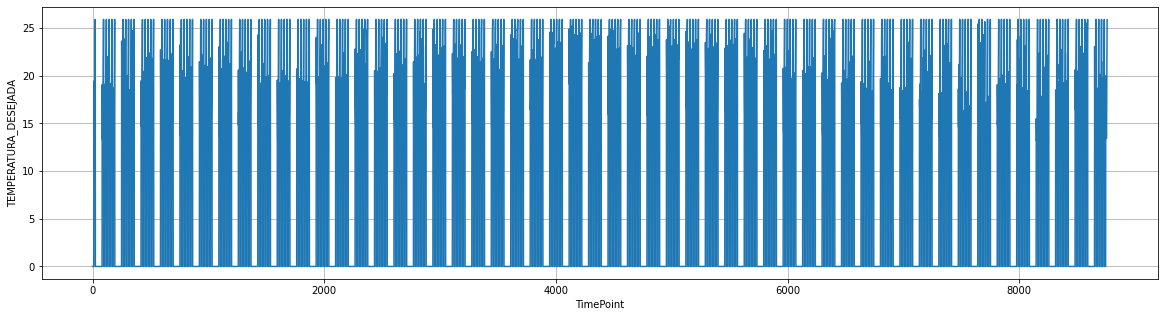

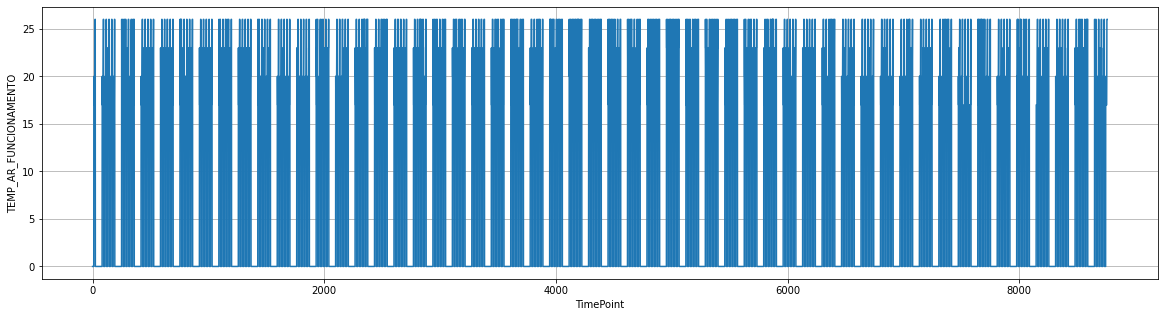

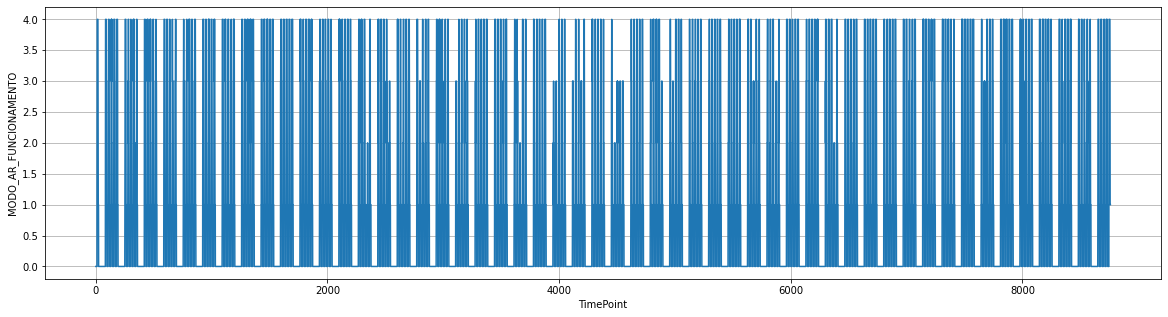

In [ ]:
for i in range(10, len(df.columns)):
  # Plotagem da série tempotal do dados de cada coluna
  plt.figure(figsize=[20,5])
  plt.xlabel('TimePoint')
  plt.ylabel(df.columns[i])
  plt.grid()
  plt.plot(df[df.columns[i]]);

In [ ]:
# SELEÇÃO DOS DADOS DE ENTRADAS (x) PARA TREINO E TESTE
x = df.iloc[:, 0:10]
x

,PRE_INS,RAD_GLO,PTO_INS,CHUVA,TEM_INS,UMD_INS,HR_MEDICAO,DIA_SEMANA,DIA_MES,MES
0,1009.2,-3.600,22.40,0.0,25.0,85.0,0,5,1,1
1,1009.3,-3.600,22.20,0.0,24.5,87.0,100,5,1,1
2,1009.2,-3.600,22.40,0.0,24.3,89.0,200,5,1,1
3,1009.2,-3.600,22.30,0.0,24.1,90.0,300,5,1,1
4,1009.0,-3.380,22.25,0.0,24.0,90.0,400,5,1,1
...,...,...,...,...,...,...,...,...,...,...
8755,1004.2,2179.970,21.30,0.0,29.9,60.0,1900,5,31,12
8756,1004.5,1269.126,22.20,0.0,29.2,66.0,2000,5,31,12
8757,1004.8,371.161,22.20,0.0,26.8,76.0,2100,5,31,12
8758,1005.9,7.194,22.60,0.0,25.8,82.0,2200,5,31,12


In [ ]:
# SELEÇÃO DOS DADOS DE SAIDAS (y) CLASSES, PARA TREINO E TESTE DE CLASSIFICAÇÃO
y = df.iloc[:, -1]
y

0       0
1       0
2       0
3       0
4       0
       ..
8755    4
8756    3
8757    1
8758    1
8759    1
Name: MODO_AR_FUNCIONAMENTO, Length: 8760, dtype: int64

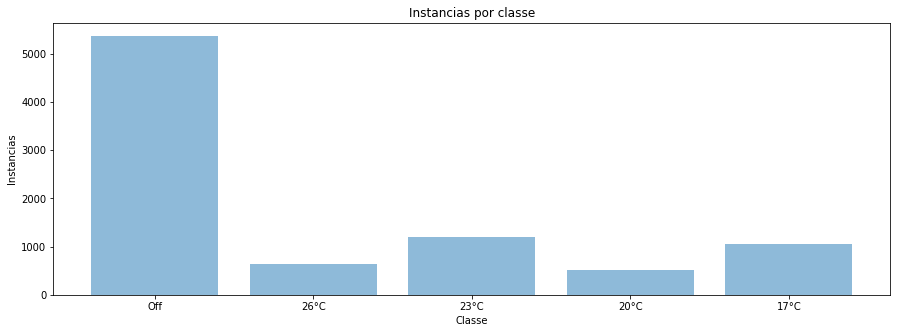

In [ ]:
# NOMEAÇÕES DAS CLASSES Y
classes = ["Off", "26°C", "23°C", "20°C", "17°C"]
num_classes = len(classes)

# Gráfico de instâncias por classe
plt.figure(figsize=(15,5))
plt.bar(classes, Counter(y).values(), align='center', alpha=0.5)
plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('Instancias por classe')
plt.show()

## Divisão e Nomarlização dos Dados

Normalização de X para que os valores fiquem na faixa de  [0  ; 1] 

Além do conjunto de testes, nescessitamos do conjunto de validação. train_test_split do sklearn divide o dataset de acordo com a porcentagem do parametro test_size

In [ ]:
# DIVISÃO DO DATASET (TREINAMENTO COM 70%) E (TESTE COM 30%):

# APLICAÇÃO DA FUNÇÃO: sklearn.model_selection.train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # divisão para treino e teste

# Uso do MinMaxScaler para normalizar o conjunto de treinamento e testes entre 0 e 1.
scaler = MinMaxScaler(feature_range=(0, 1))

# normalização das entradas x do dataset
df_train = scaler.fit_transform(x)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


In [ ]:
# Balanceamento das Classes, aplicando a função SMOTE

from imblearn.over_sampling import SMOTE
#SMOTE
smote = SMOTE(random_state = 32)
x_train, y_train = smote.fit_resample(x_train, y_train)

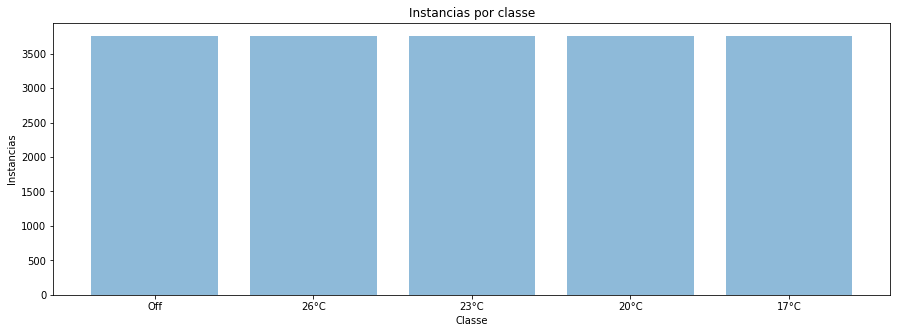

In [ ]:
# Gráfico de instâncias por classe, após o balanceamento dos dados
plt.figure(figsize=(15,5))
plt.bar(classes, Counter(y_train).values(), align='center', alpha=0.5)
plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('Instancias por classe')
plt.show()

In [ ]:
# Valores do shape dos dados de treino e teste
# x
print('Shape de x_train', x_train.shape)
print('Shape de x_test', x_test.shape)
# y
print('Shape de y_train', y_train.shape)
print('Shape de y_test', y_test.shape)

Shape de x_train (18785, 10)
Shape de x_test (2628, 10)
Shape de y_train (18785,)
Shape de y_test (2628,)


In [ ]:
# Convertendo o vetor objetivo para uma matriz de classes
y_train_linear = y_train # valores de y para treinar o modelo wide and deep posteriormente
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Construção da Rede Neural Artificial: Multi Layer Perceptron (MLP)

Modelo: objeto do tipo Sequential (sequência de camadas)

In [ ]:
#K.clear_session() # para liberar memória quando precisar

model = tf.keras.models.Sequential()

Adicionando a primeira camada densa (fully-connected)

Hyper-parâmetros da camada:
- número de neurônios: 128
- função de ativação: ReLU
- input_shape (camada de entrada): (10, ) # Correspondente ao número de tipos de variáveis independentes

In [ ]:
model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(10, )))

Adicionando Dropout e mais camadas Dense

Dropout é uma técnica para amenizar ocorrência de overfitting, na qual alguns neurônios da camada são desativados.

In [ ]:
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))


Adicionando a camada de saída

units: número de classes (5)
função de ativação: softmax

In [ ]:
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

Compilando o modelo

Optimizer (otimizador): Adam
Loss (função de erro): Sparse softmax (categorical) crossentropy 

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [ ]:
# VISUALIZAÇÃO DAS CAMADAS DO MODELO
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

Treinando o modelo

In [ ]:
# Definição dos valores de épocas (rodadas de ajustes de pesos) e batch_size (tamanho do lote de ajuste dos pesos)
epochs = 40
bs = 100

In [ ]:
# Treinando o modelo, e armazenando o resultado do treinamento em uma variável
hist = model.fit(x_train, y_train,
                 epochs = epochs,
                 batch_size = bs,
                 validation_split=0.50,
                 verbose=1)

Epoch 1/40
94/94 [==============================] - 2s 7ms/step - loss: 0.7854 - accuracy: 0.7337 - val_loss: 1.3416 - val_accuracy: 0.3352
Epoch 2/40
94/94 [==============================] - 0s 4ms/step - loss: 0.4228 - accuracy: 0.8407 - val_loss: 0.9249 - val_accuracy: 0.5464
Epoch 3/40
94/94 [==============================] - 0s 4ms/step - loss: 0.3285 - accuracy: 0.8687 - val_loss: 0.6467 - val_accuracy: 0.7192
Epoch 4/40
94/94 [==============================] - 0s 4ms/step - loss: 0.2662 - accuracy: 0.8958 - val_loss: 0.5583 - val_accuracy: 0.7936
Epoch 5/40
94/94 [==============================] - 0s 4ms/step - loss: 0.2391 - accuracy: 0.9046 - val_loss: 0.5207 - val_accuracy: 0.7983
Epoch 6/40
94/94 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9181 - val_loss: 0.3655 - val_accuracy: 0.8965
Epoch 7/40
94/94 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9257 - val_loss: 0.4152 - val_accuracy: 0.8523
Epoch 8/40
94/94 [==

## Resultados da MLP

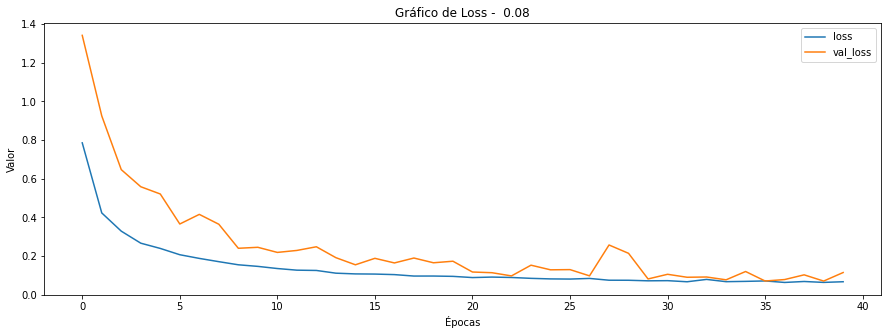

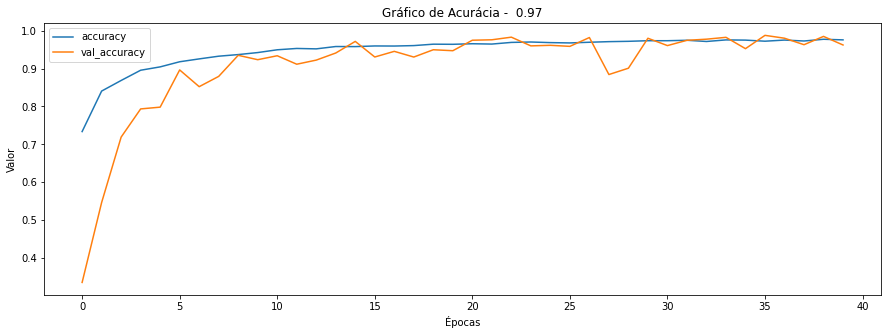

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)

# Gráfico de loss
plt.figure(figsize=(15,5))
plt.title(f"Gráfico de Loss - {scores[0]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

# Gráfico de acurácia
plt.figure(figsize=(15,5))
plt.title(f"Gráfico de Acurácia - {scores[1]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(hist.history['accuracy'], label="accuracy")
plt.plot(hist.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

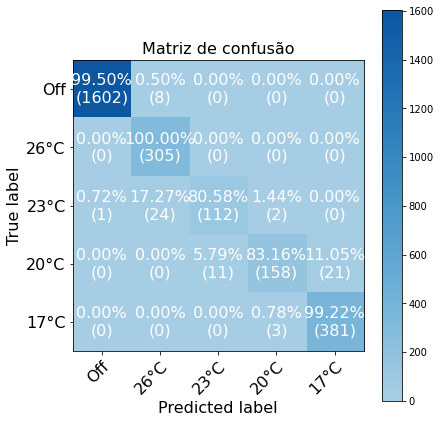

None

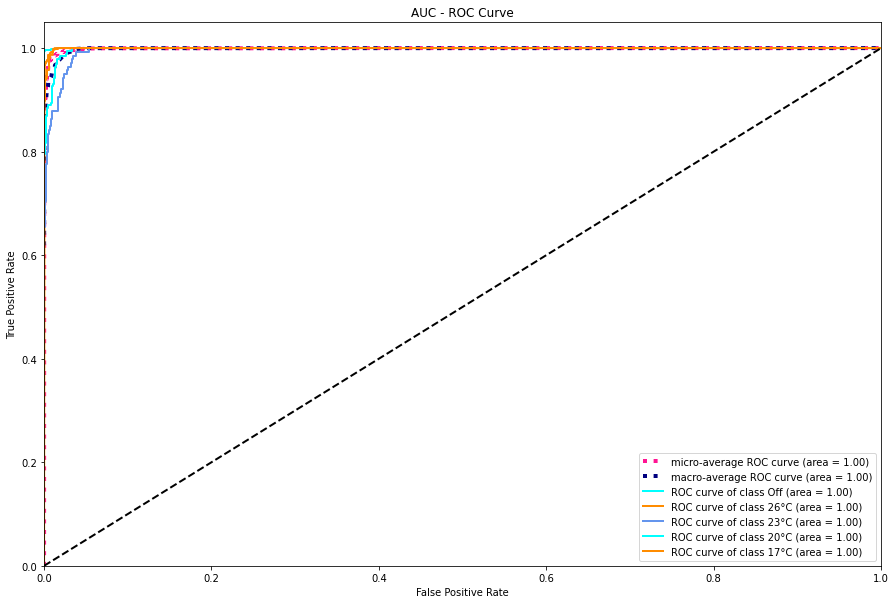

None

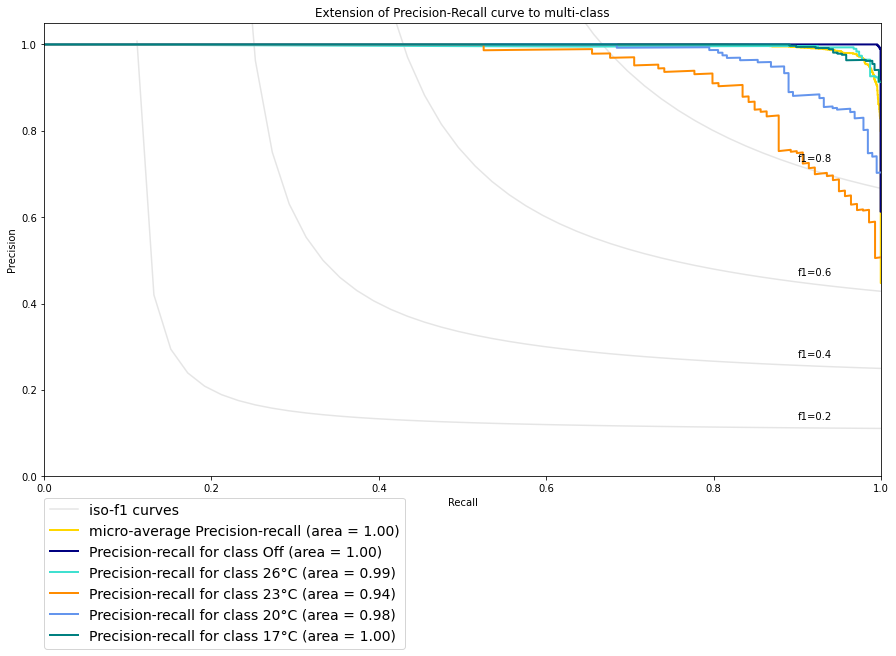

None

In [ ]:
## Resultados

# fazer as predições
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)


pyaiutils.plot_graphics(y_test, testPredict, classes )
# It will present three graphics, as follows:
# - Confusion matrix
# - AUC ROC curve
# - AUC PRC curve


In [ ]:
# RESULTADOS
pyaiutils.get_metrics(y_test, testPredict, classes )
#  It will present a table with a set of metrics for model validation.
#  The metrics are:
# - F1-score
# - ROC Auc
# - PRC AUC
# - Precision
# - Recall
# - Specificity
# - Accuracy
# '''

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,Off,1.00,1.0,1.00,1.00,1.00,1.00,1.00
1,26°C,0.95,1.0,0.99,0.91,1.00,0.99,0.99
2,23°C,0.85,1.0,0.94,0.91,0.81,1.00,0.99
3,20°C,0.90,1.0,0.98,0.97,0.83,1.00,0.99
4,17°C,0.97,1.0,1.00,0.95,0.99,0.99,0.99
5,Média,0.93,1.0,0.98,0.95,0.93,1.00,0.99


## Modelo Wide and Deep

https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel

Nesta etapa será treinado um modelo linear conjuntamente com o modelo dnn.

In [ ]:
## MODELO LINEAR "WIDE"
linear_model = LinearModel()
linear_model.compile('adagrad', 'mse', metrics=["mae", "acc"])
linear_model.fit(x_train, y_train_linear, epochs= 20)

Epoch 1/20
588/588 [==============================] - 1s 1ms/step - loss: 5.3687 - mae: 1.9010 - acc: 0.2000
Epoch 2/20
588/588 [==============================] - 1s 1ms/step - loss: 4.8682 - mae: 1.8155 - acc: 0.2000
Epoch 3/20
588/588 [==============================] - 1s 1ms/step - loss: 4.5715 - mae: 1.7618 - acc: 0.1962
Epoch 4/20
588/588 [==============================] - 1s 1ms/step - loss: 4.3481 - mae: 1.7191 - acc: 0.1926
Epoch 5/20
588/588 [==============================] - 1s 1ms/step - loss: 4.1659 - mae: 1.6830 - acc: 0.2259
Epoch 6/20
588/588 [==============================] - 1s 1ms/step - loss: 4.0114 - mae: 1.6512 - acc: 0.2315
Epoch 7/20
588/588 [==============================] - 1s 1ms/step - loss: 3.8769 - mae: 1.6226 - acc: 0.2215
Epoch 8/20
588/588 [==============================] - 1s 1ms/step - loss: 3.7582 - mae: 1.5965 - acc: 0.2126
Epoch 9/20
588/588 [==============================] - 1s 1ms/step - loss: 3.6517 - mae: 1.5724 - acc: 0.2069
Epoch 10/20
588/588

In [ ]:
combined_model = WideDeepModel(linear_model, model)
combined_model.compile(optimizer=['sgd', 'adam'], loss='mse', metrics=['accuracy'])
histWD = combined_model.fit([x_train, x_train], y_train,  batch_size = bs, epochs = epochs, validation_split=0.50,)

Epoch 1/40
94/94 [==============================] - 1s 6ms/step - loss: 0.0913 - accuracy: 0.9764 - val_loss: 0.0084 - val_accuracy: 0.9886
Epoch 2/40
94/94 [==============================] - 1s 5ms/step - loss: 0.0095 - accuracy: 0.9761 - val_loss: 0.0081 - val_accuracy: 0.9852
Epoch 3/40
94/94 [==============================] - 0s 5ms/step - loss: 0.0080 - accuracy: 0.9781 - val_loss: 0.0074 - val_accuracy: 0.9833
Epoch 4/40
94/94 [==============================] - 0s 4ms/step - loss: 0.0088 - accuracy: 0.9751 - val_loss: 0.0095 - val_accuracy: 0.9780
Epoch 5/40
94/94 [==============================] - 0s 5ms/step - loss: 0.0076 - accuracy: 0.9770 - val_loss: 0.0092 - val_accuracy: 0.9739
Epoch 6/40
94/94 [==============================] - 0s 5ms/step - loss: 0.0072 - accuracy: 0.9791 - val_loss: 0.0192 - val_accuracy: 0.9377
Epoch 7/40
94/94 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 0.9809 - val_loss: 0.0104 - val_accuracy: 0.9655
Epoch 8/40
94/94 [==

In [ ]:
# composição do modelo wide and deep
combined_model.summary()

Model: "wide_deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_model (LinearModel)  multiple                  11        
                                                                 
 sequential (Sequential)     (None, 5)                 32581     
                                                                 
Total params: 32,592
Trainable params: 32,592
Non-trainable params: 0
_________________________________________________________________


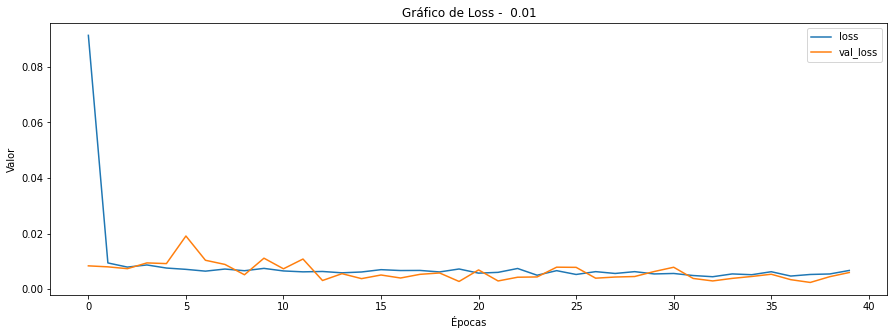

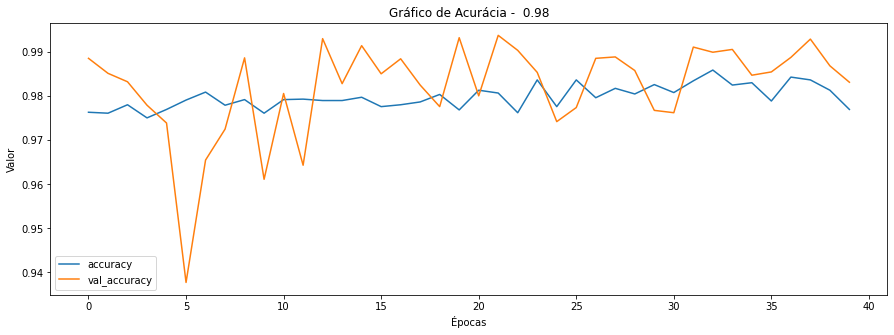

In [ ]:
# Final evaluation of the model wide and deep
scoresWD = combined_model.evaluate(x_test, y_test, verbose=0)

# Gráfico de loss
plt.figure(figsize=(15,5))
plt.title(f"Gráfico de Loss - {scoresWD[0]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(histWD.history['loss'], label="loss")
plt.plot(histWD.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

# Gráfico de acurácia
plt.figure(figsize=(15,5))
plt.title(f"Gráfico de Acurácia - {scoresWD[1]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(histWD.history['accuracy'], label="accuracy")
plt.plot(histWD.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

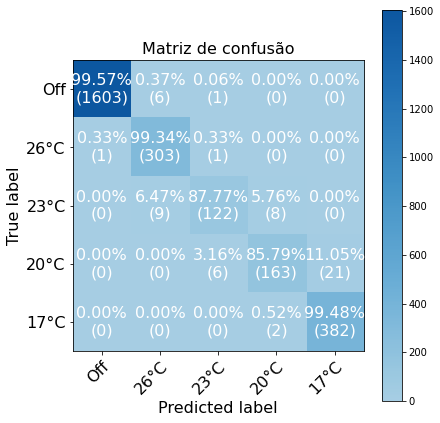

None

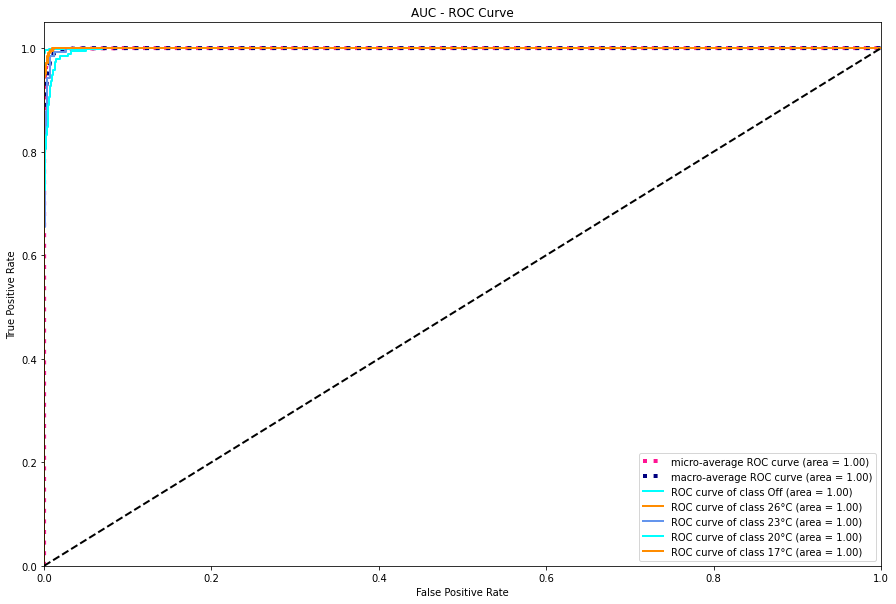

None

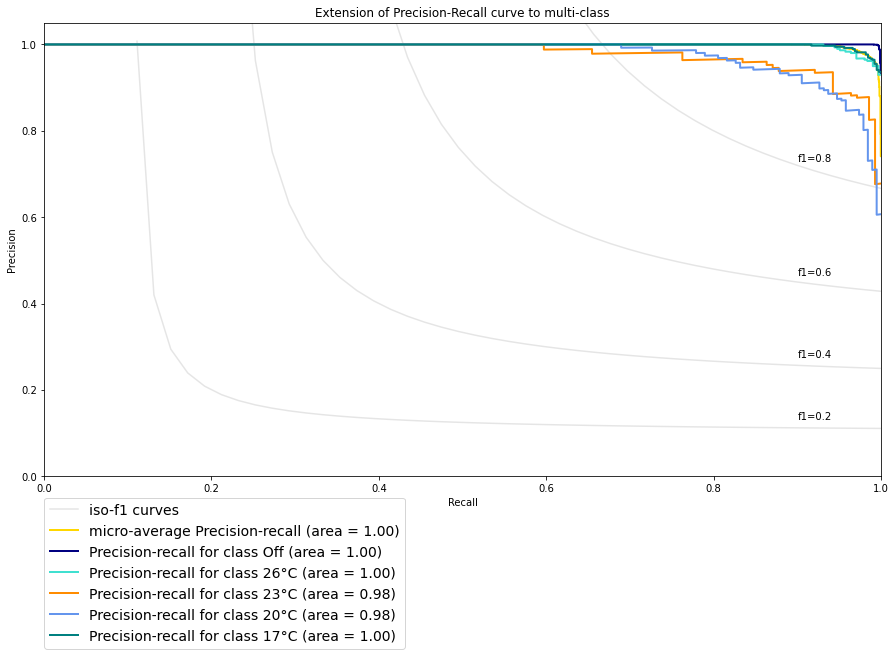

None

In [ ]:
## Resultados Wide and Deep

# faz as predições
WDtrainPredict = combined_model.predict(x_train)
WDtestPredict = combined_model.predict(x_test)


pyaiutils.plot_graphics(y_test, WDtestPredict, classes )
# It will present three graphics, as follows:
# - Confusion matrix
# - AUC ROC curve
# - AUC PRC curve

In [ ]:
# RESULTADOS DO MODELO WIDE AND DEEP
pyaiutils.get_metrics(y_test, WDtestPredict, classes )
#  It will present a table with a set of metrics for model validation.
#  The metrics are:
# - F1-score
# - ROC Auc
# - PRC AUC
# - Precision
# - Recall
# - Specificity
# - Accuracy
# '''

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,Off,1.00,1.0,1.00,1.00,1.00,1.00,1.00
1,26°C,0.97,1.0,1.00,0.95,0.99,0.99,0.99
2,23°C,0.91,1.0,0.98,0.94,0.88,1.00,0.99
3,20°C,0.90,1.0,0.98,0.94,0.86,1.00,0.99
4,17°C,0.97,1.0,1.00,0.95,0.99,0.99,0.99
5,Média,0.95,1.0,0.99,0.96,0.94,1.00,0.99


## Modelo de Redes LSTM

In [ ]:
# divisão dos dados
base_train = x.values
train_size = len(base_train)*0.7 # 70% para treino e 30% para teste
print(train_size)

6132.0


In [ ]:
# divisão dos dados
base_train = x.values
y_base = y.values
train_size = 6100

# dados de treino e teste
passado_train, passado_test = base_train[0:train_size,:], base_train[train_size:len(base_train),:]
print('Dataset x de treinamento contém: ', len(passado_train),' dados')
print('Dataset x de teste contém: ', len(passado_test),' dados')

resposta_train, resposta_test = y_base[0:train_size], y_base[train_size:len(y_base)]
print('Dataset y de treinamento contém: ', len(resposta_train),' dados')
print('Dataset y de teste contém: ', len(resposta_test),' dados')


#normalização dos dados de entradas
# Uso do MinMaxScaler para normalizar o conjunto de treinamento e testes entre 0 e 1.
scal = MinMaxScaler(feature_range=(0, 1))

# normalize the dataset
datalstm_train = scal.fit_transform(x.values)
passado_trainlstm = scal.transform(passado_train)
passado_testlstm = scal.transform(passado_test)


Dataset x de treinamento contém:  6100  dados
Dataset x de teste contém:  2660  dados
Dataset y de treinamento contém:  6100  dados
Dataset y de teste contém:  2660  dados


In [ ]:
# construção do timestamp em função do valor de lock back # o dataset das entradas serão em forma de série temporal
lookback = 48 # o número dos últimos registros para compor a entrada de dados

passado = []
resposta = []
for i in range(lookback, len(passado_trainlstm)):
    passado.append(passado_trainlstm[i - lookback:i , 0: passado_trainlstm.shape[1]]) # todos os atributos x de entradas serão considerados
    resposta.append(resposta_train[i])
passado_xtrain, resposta_ytrain = np.array(passado), np.array(resposta) # ajuste do formato dos dados, de lista para array

#

passado_ts = []
resposta_ts = []
resposta = []
for i in range(lookback, len(passado_testlstm)):
    passado_ts.append(passado_testlstm[i - lookback:i , 0: passado_testlstm.shape[1]]) # todos os atributos x de entradas serão considerados
    resposta_ts.append(resposta_test[i])
passado_xtest, resposta_ytest = np.array(passado_ts), np.array(resposta_ts) # ajuste do formato dos dados, de lista para array



# Convertendo o vetor objetivo para uma matriz de classes
ytrain = to_categorical(resposta_ytrain, num_classes)
ytest = to_categorical(resposta_ytest, num_classes)

In [ ]:
# Construção do modelo LSTM com camadas LSTM, Dropout e Dense

modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 100, return_sequences = True, input_shape = (passado_xtrain.shape[1], passado_xtrain.shape[2])))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(LSTM(units = 50, return_sequences = True))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(LSTM(units = 50, return_sequences = True))
modelLSTM.add(Dropout(0.3))
modelLSTM.add(LSTM(units = 50))
modelLSTM.add(Dropout(0.3))

modelLSTM.add(Dense(units = num_classes, activation = 'softmax'))

modelLSTM.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])


# composição do modelo LSTM
modelLSTM.summary()

histLSTM = modelLSTM.fit(passado_xtrain, ytrain,
                 epochs = 20,
                 batch_size = bs,
                 validation_split=0.50,
                 verbose=1)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 100)           44400     
                                                                 
 dropout_5 (Dropout)         (None, 48, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 50)            30200     
                                                                 
 dropout_6 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

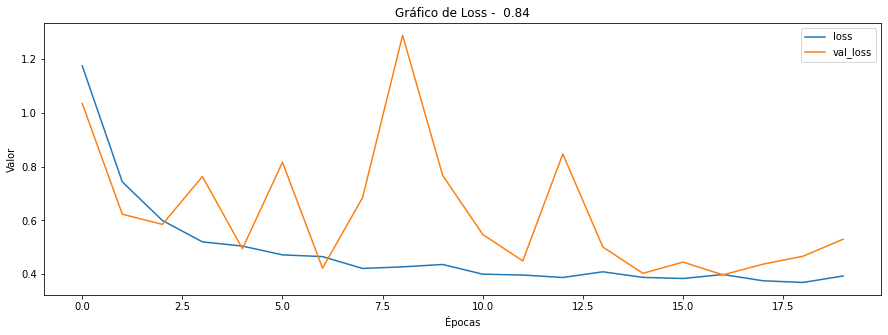

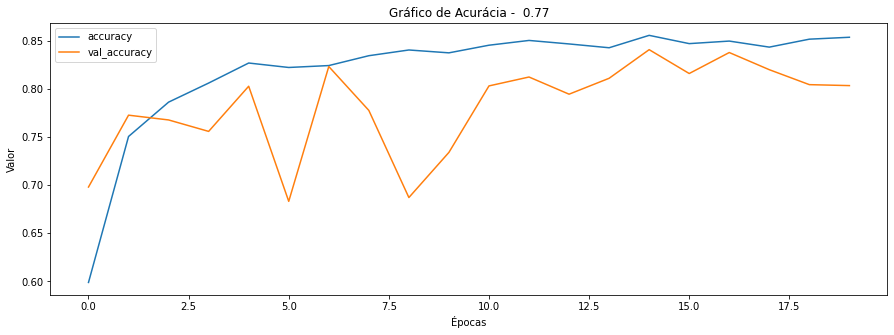

In [ ]:
# Final evaluation of the model LSTM
scoresLSTM = modelLSTM.evaluate(passado_xtest, ytest, verbose=0)

# Gráfico de loss
plt.figure(figsize=(15,5))
plt.title(f"Gráfico de Loss - {scoresLSTM[0]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(histLSTM.history['loss'], label="loss")
plt.plot(histLSTM.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

# Gráfico de acurácia
plt.figure(figsize=(15,5))
plt.title(f"Gráfico de Acurácia - {scoresLSTM[1]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(histLSTM.history['accuracy'], label="accuracy")
plt.plot(histLSTM.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

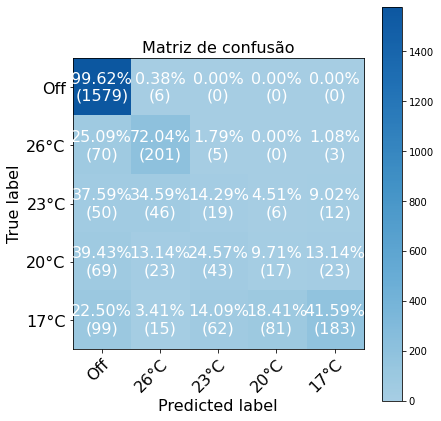

None

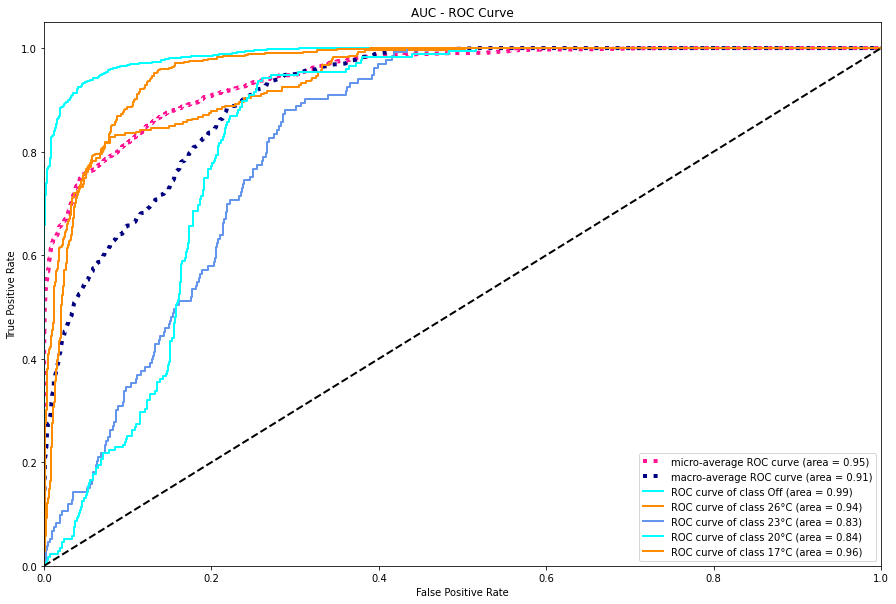

None

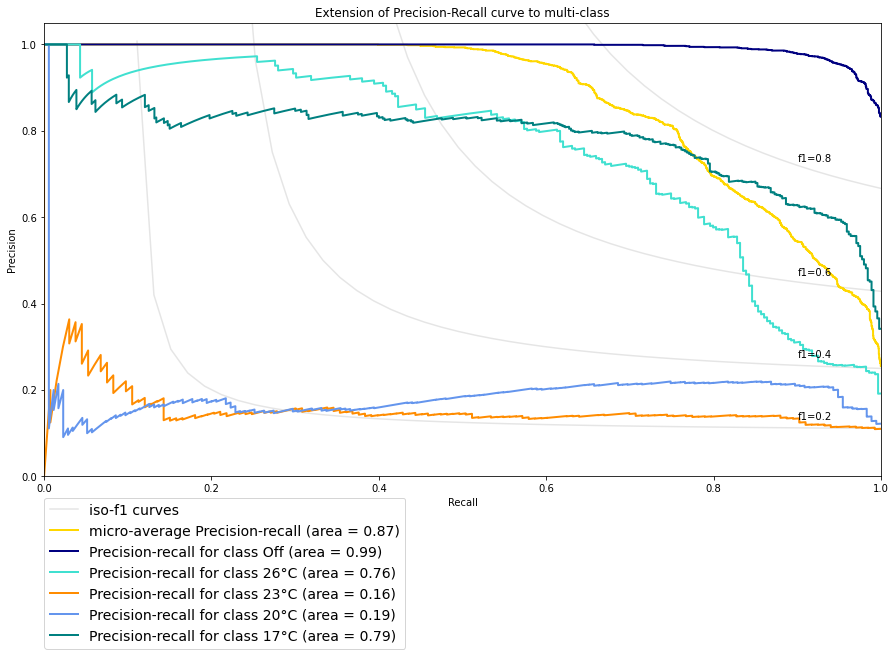

None

In [ ]:
## Resultados LSTM

# faz as predições
LSTMtrainPredict = modelLSTM.predict(passado_xtrain)
LSTMtestPredict = modelLSTM.predict(passado_xtest)


pyaiutils.plot_graphics(ytest, LSTMtestPredict, classes )
# It will present three graphics, as follows:
# - Confusion matrix
# - AUC ROC curve
# - AUC PRC curve

In [ ]:
# RESULTADOS DO MODELO LSTM
pyaiutils.get_metrics(ytest, LSTMtestPredict, classes )
#  It will present a table with a set of metrics for model validation.
#  The metrics are:
# - F1-score
# - ROC Auc
# - PRC AUC
# - Precision
# - Recall
# - Specificity
# - Accuracy
# '''

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,Off,0.91,0.99,0.99,0.85,1.00,0.72,0.89
1,26°C,0.71,0.94,0.76,0.69,0.72,0.96,0.94
2,23°C,0.15,0.83,0.16,0.15,0.14,0.96,0.91
3,20°C,0.12,0.84,0.19,0.16,0.10,0.96,0.91
4,17°C,0.55,0.96,0.79,0.83,0.42,0.98,0.89
5,Média,0.49,0.91,0.58,0.54,0.48,0.92,0.91


## Conclusão

O modelo MLP apresentou melhor desempenho nos resultados comparados aos dos modelos Wide and Deep e de Redes LSTM. Associada a elevada precisão dos resultados obtidos com o modelo MLP, este também obteve menor complexidade de programação e menor custo computacional (tempo de processamento e ocupação de memória). Portanto, dentre os modelos testados, o modelo MLP seria o indicado para a aplicação de um conjunto de dados anual das variáveis horárias meteorológicas, para a realizar a aprendizagem de máquina supervisionada, a fim de, obter-se o controle automático de funcionamento e de ajustes de temperaturas de um aparelho de ar-condicionado.